In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as bar
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT = "CIND820_Streaming_and_Cultural_Exports"
root = Path.cwd()
while root.name != PROJECT and root.parent != root:
    root = root.parent
if root.name != PROJECT:
    root = Path.cwd() / PROJECT  #fallback

FIG_DIR = root / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Saving figures to:", FIG_DIR)

def savefig(fig, name: str):
    p = FIG_DIR / f"{name}.png"
    fig.savefig(p, dpi=300, bbox_inches="tight")
    print("Saved:", p)

#General settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

#Load Data
df = pd.read_csv("clean_streaming_metadata.csv")
print("Shape:", df.shape)
df.info()

Saving figures to: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures
Shape: (12855, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12855 entries, 0 to 12854
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           12855 non-null  object 
 1   type            12855 non-null  object 
 2   release_year    12855 non-null  int64  
 3   genres          12855 non-null  object 
 4   platform        12855 non-null  object 
 5   content_rating  12702 non-null  object 
 6   imdb_rating     12855 non-null  float64
 7   imdb_votes      12855 non-null  float64
 8   country         12855 non-null  object 
 9   tconst          12855 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1004.4+ KB


In [32]:
#View and check for missing values
df.head()
df.isna().sum().sort_values(ascending=False)

content_rating    153
title               0
type                0
release_year        0
genres              0
platform            0
imdb_rating         0
imdb_votes          0
country             0
tconst              0
dtype: int64

In [33]:
#Base descriptive statistics for the numeric fields
print(df["release_year"].describe())
print(df["imdb_rating"].describe())

#Type (Movie vs TV)
type_dist = df["type"].value_counts(normalize=True) * 100
print(f"\n{type_dist}")

count    12855.000000
mean      2009.938934
std         16.667641
min       1920.000000
25%       2009.000000
50%       2016.000000
75%       2019.000000
max       2021.000000
Name: release_year, dtype: float64
count    12855.000000
mean         6.223003
std          1.254114
min          1.000000
25%          5.500000
50%          6.400000
75%          7.100000
max          9.600000
Name: imdb_rating, dtype: float64

type
Movie      78.016336
TV Show    21.983664
Name: proportion, dtype: float64


Saved: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures/titles_by_platform.png


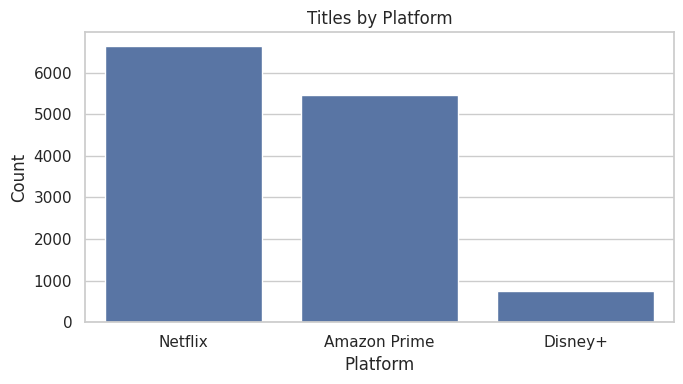

In [34]:
#Bar chart for total titles for each platform
fig = bar.figure(figsize=(7,4))
sns.countplot(data=df, x="platform", order=df["platform"].value_counts().index)
bar.title("Titles by Platform")
bar.xlabel("Platform")
bar.ylabel("Count")
bar.tight_layout()

fig.savefig(FIG_DIR / "titles_by_platform.png", dpi=300, bbox_inches="tight")
print("Saved:", FIG_DIR / "titles_by_platform.png")

bar.show()

In [35]:
#One-hotencode genres
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import chain
import ast

def parse_genres(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, list):
        return [str(i).strip() for i in x if str(i).strip().lower() != "unknown"]
    s = str(x)
    # split on '|' or ',' if present
    for sep in ["|", ","]:
        if sep in s:
            return [t.strip() for t in s.split(sep) if t.strip() and t.strip().lower() != "unknown"]
    s = s.strip()
    return [s] if s and s.lower() != "unknown" else []

#Collapse case/spacing and fix plurals/typos
NORMALIZE_GENRE = {
    "comedies": "Comedy",
    "dramas": "Drama",
    "documentaries": "Documentary",
    "documetary": "Documentary",
    "sci fi": "Sci-Fi",
    "science fiction": "Sci-Fi",
    "stand up comedy": "Stand-Up Comedy",
    "kid": "kids"
}
PROTECTED = {"News"}

def normalize_genre(g: str) -> str:
    s = str(g).strip().lower()
    s = " ".join(s.split())
    if s in NORMALIZE_GENRE:
        return NORMALIZE_GENRE[s]
    #default singularization for trailing 's'
    if s.endswith("s"):
        cand = s[:-1].title()
        if cand not in PROTECTED:
            return cand
    return s.title()


def freq_from_lists(series, topn=10):
    flat = list(chain.from_iterable(series))
    return pd.Series(flat).value_counts().head(topn)


genre_lists = df["genres"].apply(parse_genres).apply(lambda lst: [normalize_genre(g) for g in lst])

TOP_K = 20
if TOP_K is not None:
    freq = (
        pd.Series([g for lst in genre_lists for g in lst])
          .value_counts()
          .head(TOP_K)
          .index
    )
    genre_lists = genre_lists.apply(lambda lst: [g for g in lst if g in set(freq)])

#MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=True)
G_sparse = mlb.fit_transform(genre_lists)

genre_df = pd.DataFrame.sparse.from_spmatrix(
    G_sparse,
    index=df.index,
    columns=[f"genre_{g}" for g in mlb.classes_]
)

#Attach to df
df = pd.concat([df, genre_df], axis=1)

print(f"Added {genre_df.shape[1]} genre features; df shape now: {df.shape}")


Added 20 genre features; df shape now: (12855, 30)


Saved: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures/top_countries.png


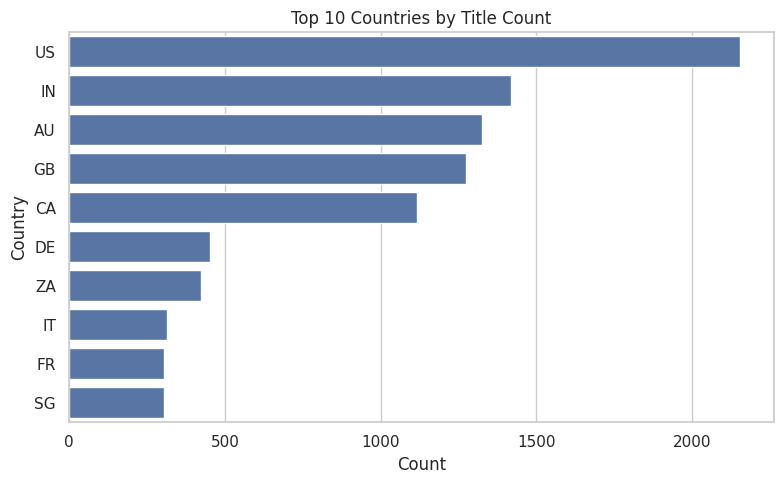

In [36]:
#Bar chart for Country and Genre frequency 

def to_list(x):
    if pd.isna(x): 
        return []
    if isinstance(x, list):
        return [str(i) for i in x]
    s = str(x).strip()
    #Try Python/JSON-like list
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list): 
            return [str(i) for i in v]
        if isinstance(v, (str, int, float)): 
            return [str(v)]
    except Exception:
        pass
    if "," in s:
        return [t.strip() for t in s.split(",") if t.strip()]
    return [] if s in ("", "nan", "None") else [s]

def freq_list_column(series, topn=10):
    flat = [item for sub in series.dropna().map(to_list) for item in sub if item]
    return pd.Series(flat).value_counts().head(topn)

if df["country"].astype(str).str.startswith("[").any() or df["country"].astype(str).str.contains(",").any():
    top_countries = freq_list_column(df["country"], topn=10)
else:
    top_countries = (
        df["country"].dropna().astype(str).str.upper().str.strip().value_counts().head(10)
    )
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=top_countries.values, y=top_countries.index, ax=ax)
ax.set_title("Top 10 Countries by Title Count")
ax.set_xlabel("Count"); ax.set_ylabel("Country")
savefig(fig, "top_countries")

plt.tight_layout()
plt.show()



Saved: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures/content_release_trends_by_platform.png


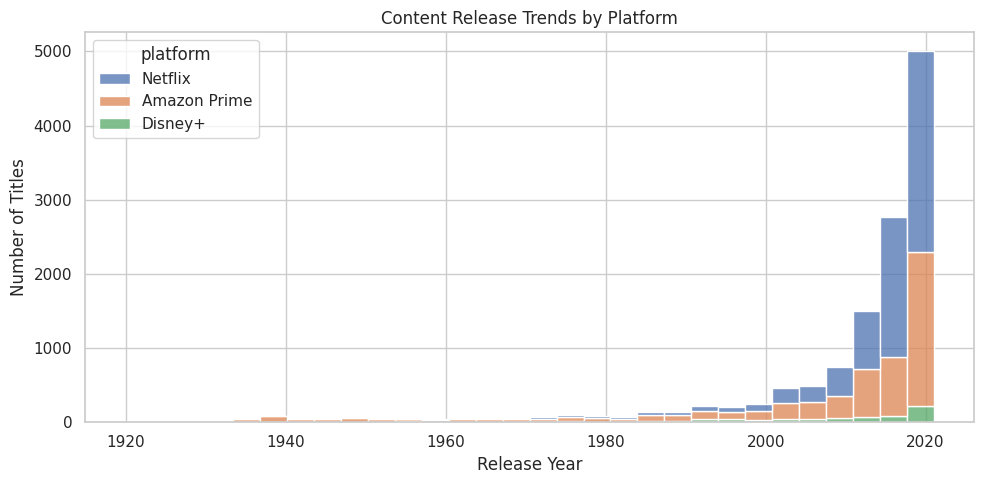

Saved: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures/imdb_rating_distribution_by_platform.png


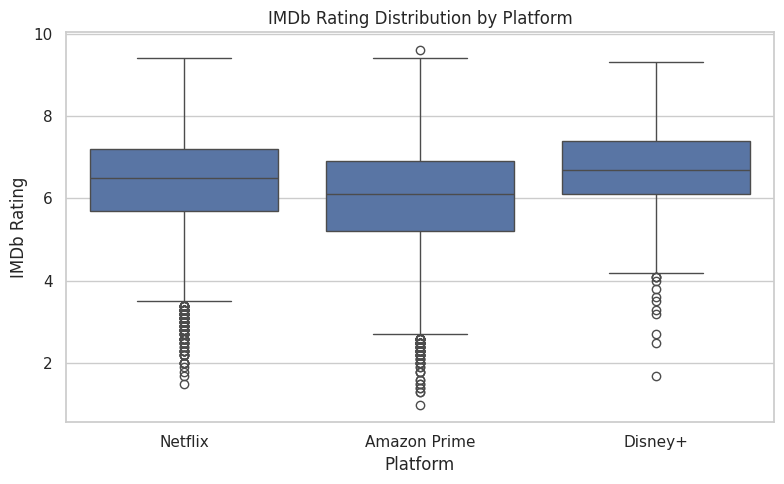

In [37]:
#Chart for content release over years

plt.figure(figsize=(10,5))
sns.histplot(df, x="release_year", hue="platform", multiple="stack", bins=30)
plt.title("Content Release Trends by Platform")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")

plt.tight_layout()
plt.savefig(FIG_DIR / "content_release_trends_by_platform.png", dpi=300, bbox_inches="tight")
print("Saved:", FIG_DIR / "content_release_trends_by_platform.png")


plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="platform", y="imdb_rating")
plt.title("IMDb Rating Distribution by Platform")
plt.xlabel("Platform")
plt.ylabel("IMDb Rating")

plt.tight_layout()
plt.savefig(FIG_DIR / "imdb_rating_distribution_by_platform.png", dpi=300, bbox_inches="tight")
print("Saved:", FIG_DIR / "imdb_rating_distribution_by_platform.png")

plt.show()


CWD: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/notebooks  | Saving to: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures


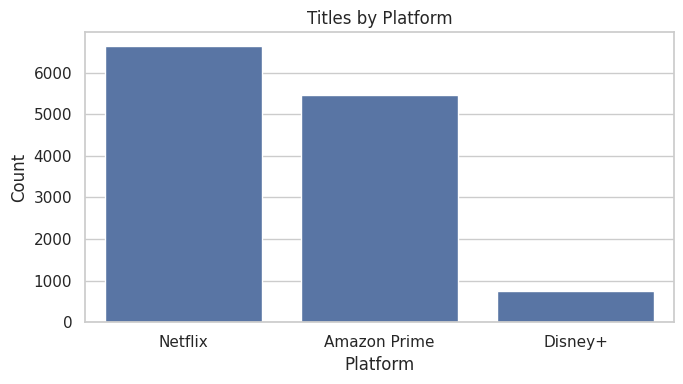

Saved: ../figures/platform_distribution.png


In [38]:
FIG_DIR = pathlib.Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("CWD:", os.getcwd(), " | Saving to:", FIG_DIR.resolve())

def savefig(fig, name):
    path = FIG_DIR / f"{name}.png"
    fig.savefig(path, dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.close(fig)
    print("Saved:", path)

#Platform distribution
fig, ax = plt.subplots(figsize=(7,4))
sns.countplot(data=df, x="platform",
              order=df["platform"].value_counts().index, ax=ax)
ax.set_title("Titles by Platform")
ax.set_xlabel("Platform"); ax.set_ylabel("Count")
fig.tight_layout()
savefig(fig, "platform_distribution")

In [39]:
# 1) What columns mention "imdb"?
[c for c in df.columns if "imdb" in c.lower()]

# 2) Basic diagnostics
print("dtype:", df["imdb_rating"].dtype)
print("non-null count:", df["imdb_rating"].notna().sum())
print(df["imdb_rating"].dropna().head(10))

# 3) If dtype is 'object' or values look like strings, coerce to numeric
df["imdb_rating"] = pd.to_numeric(df["imdb_rating"], errors="coerce")

# 4) After coercion
print("dtype (post):", df["imdb_rating"].dtype)
print("non-null (post):", df["imdb_rating"].notna().sum())
df["imdb_rating"].describe()


dtype: float64
non-null count: 12855
0    7.4
1    6.7
2    7.2
3    6.5
4    7.7
5    6.8
6    7.0
7    6.4
8    6.7
9    5.9
Name: imdb_rating, dtype: float64
dtype (post): float64
non-null (post): 12855


count    12855.000000
mean         6.223003
std          1.254114
min          1.000000
25%          5.500000
50%          6.400000
75%          7.100000
max          9.600000
Name: imdb_rating, dtype: float64

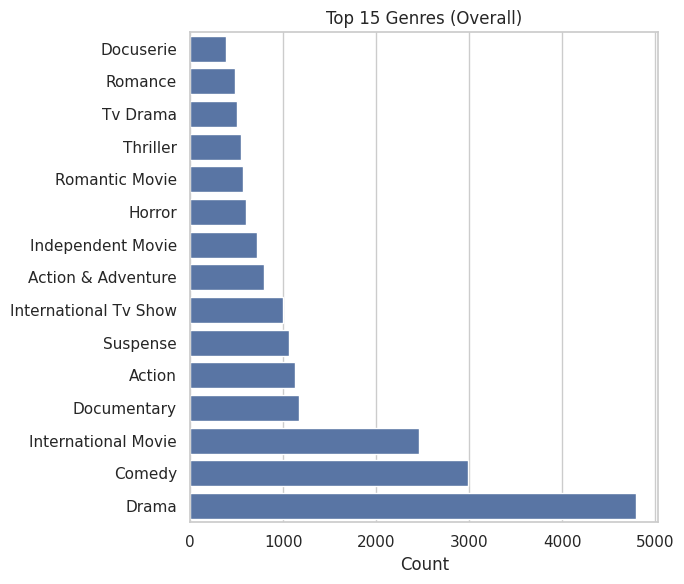

Saved: ../figures/eda_top_15_genres_overall.png


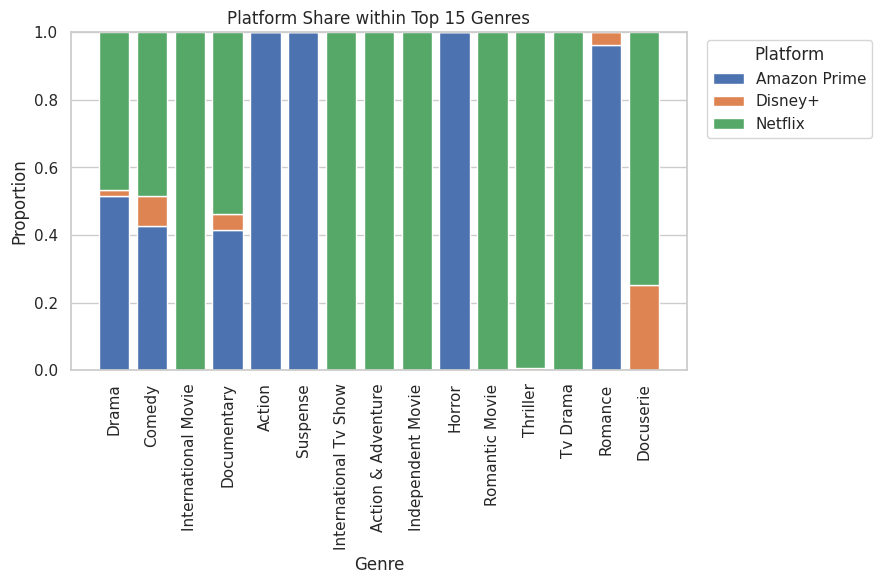

Saved: ../figures/eda_platform_share_within_top_15_genres.png


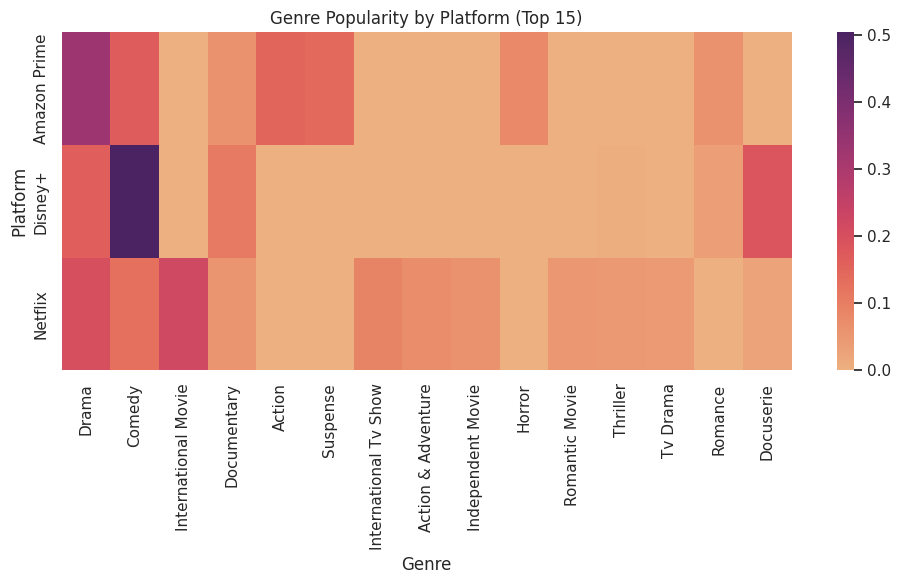

Saved: ../figures/eda_heatmap_platform_by_genre_top_15.png
Saved figures to: ../figures


In [40]:
#Platform analysis by genre 

if "genres_clean" not in locals():
    genres_clean = df["genres"].apply(parse_genres).apply(lambda lst: [normalize_genre(g) for g in lst])

TOP_K = 15

#Prepare long form: one row per (row_id, genre)
exploded = (
    pd.DataFrame({"row_id": df.index, "platform": df["platform"], "genre_list": genres_clean})
      .explode("genre_list", ignore_index=True)
      .dropna(subset=["genre_list"])
      .rename(columns={"genre_list": "genre"})
)

#Keep top-K genres 
top_genres = exploded["genre"].value_counts().head(TOP_K).index
exploded_top = exploded[exploded["genre"].isin(top_genres)].copy()

#Top-K genres
g_counts_df = g_counts.rename_axis("genre").reset_index(name="count")
fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(data=g_counts_df, x="count", y="genre", ax=ax)
ax.set_title(f"Top {TOP_K} Genres (Overall)")
ax.set_xlabel("Count"); ax.set_ylabel("")
fig.tight_layout()
savefig(fig, f"eda_top_{TOP_K}_genres_overall")

#Platform share per genre
ct = (exploded_top
      .groupby(["genre", "platform"]).size()
      .unstack(fill_value=0)
      .loc[top_genres])

ct_prop = ct.div(ct.sum(axis=1), axis=0)  #within-genre platform share

fig, ax = plt.subplots(figsize=(9, 6))
bottom = np.zeros(len(ct_prop))
x = np.arange(len(ct_prop))
for i, plat in enumerate(ct_prop.columns):
    ax.bar(x, ct_prop[plat].values, bottom=bottom, label=plat)
    bottom += ct_prop[plat].values
ax.set_xticks(x)
ax.set_xticklabels(ct_prop.index, rotation=90, ha="right", va="center", rotation_mode="anchor")
fig.subplots_adjust(bottom=0.32)
ax.set_title(f"Platform Share within Top {TOP_K} Genres")
ax.set_ylabel("Proportion"); ax.set_xlabel("Genre")
ax.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.tight_layout()
savefig(fig, f"eda_platform_share_within_top_{TOP_K}_genres")

#Heatmap
#Normalize by platform
plat_prop = ct.div(ct.sum(axis=0), axis=1)  
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(plat_prop.T, annot=False, cmap="flare", ax=ax)
ax.set_title(f"Genre Popularity by Platform (Top {TOP_K})")
ax.set_xlabel("Genre"); ax.set_ylabel("Platform")
fig.tight_layout()
savefig(fig, f"eda_heatmap_platform_by_genre_top_{TOP_K}")


print("Saved figures to:", FIG_DIR)
